In [16]:
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
file_path = "prices.txt"
df = pd.read_csv(file_path)

In [18]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [19]:
df = df.dropna(subset=['Date'])

In [20]:
df = df.sort_values(by='Date')

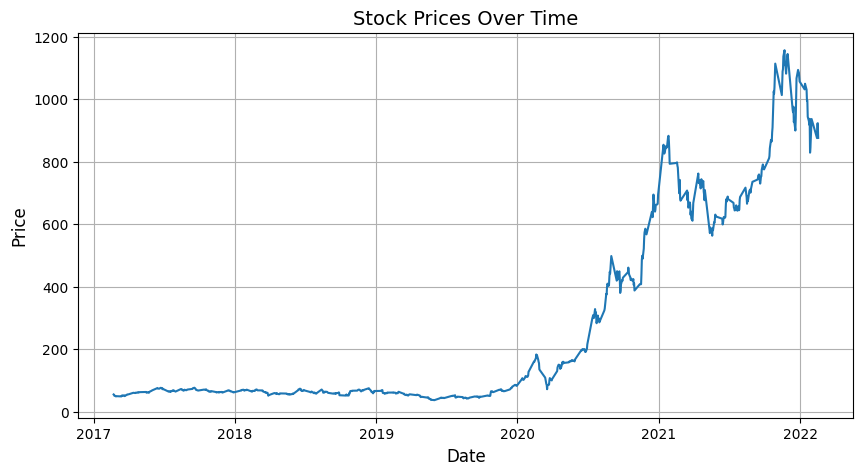

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Price'])
plt.title('Stock Prices Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True)
plt.show()

In [22]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Step 1: Normalize the 'Price' column
scaler = MinMaxScaler()
df['Normalized_Price'] = scaler.fit_transform(df[['Price']])

# Step 2: Split the data into training and testing sets
split_index = int(len(df) * 0.8)
train_data = df[:split_index]
test_data = df[split_index:]

# Step 3: Create sequences for training
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(data[i+sequence_length])
    return np.array(sequences), np.array(labels)

sequence_length = 5  # Use the past 5 prices to predict the next
train_sequences, train_labels = create_sequences(train_data['Normalized_Price'].values, sequence_length)
test_sequences, test_labels = create_sequences(test_data['Normalized_Price'].values, sequence_length)

# Output the shapes for verification
print(f"Training Sequences: {train_sequences.shape}, Training Labels: {train_labels.shape}")
print(f"Testing Sequences: {test_sequences.shape}, Testing Labels: {test_labels.shape}")


Training Sequences: (604, 5), Training Labels: (604,)
Testing Sequences: (148, 5), Testing Labels: (148,)


In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dense(1)
])


In [62]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [63]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 5, 64)             16896     
                                                                 
 dropout_4 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_15 (LSTM)              (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
train_sequences = train_sequences.reshape((train_sequences.shape[0], train_sequences.shape[1], 1))
test_sequences = test_sequences.reshape((test_sequences.shape[0], test_sequences.shape[1], 1))

In [65]:
history = model.fit(train_sequences, train_labels, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20
16/16 [==============================] - 3s 34ms/step - loss: 6.1250e-04 - val_loss: 0.1263
Epoch 2/20
16/16 [==============================] - 0s 14ms/step - loss: 3.9023e-04 - val_loss: 0.1166
Epoch 3/20
16/16 [==============================] - 0s 10ms/step - loss: 3.3189e-04 - val_loss: 0.1041
Epoch 4/20
16/16 [==============================] - 0s 9ms/step - loss: 2.8066e-04 - val_loss: 0.0841
Epoch 5/20
16/16 [==============================] - 0s 10ms/step - loss: 2.1047e-04 - val_loss: 0.0592
Epoch 6/20
16/16 [==============================] - 0s 8ms/step - loss: 1.3091e-04 - val_loss: 0.0289
Epoch 7/20
16/16 [==============================] - 0s 8ms/step - loss: 8.5631e-05 - val_loss: 0.0127
Epoch 8/20
16/16 [==============================] - 0s 9ms/step - loss: 6.8548e-05 - val_loss: 0.0101
Epoch 9/20
16/16 [==============================] - 0s 8ms/step - loss: 7.2029e-05 - val_loss: 0.0066
Epoch 10/20
16/16 [==============================] - 0s 8ms/step - loss: 6.944

In [66]:
test_loss = model.evaluate(test_sequences, test_labels, verbose=0)
print(f"Test Loss: {test_loss}")

Test Loss: 0.012764496728777885


5/5 [==============================] - 0s 3ms/step
Root Mean Squared Error (RMSE): 126.51937342170541
Mean Absolute Error (MAE): 115.28807808253273


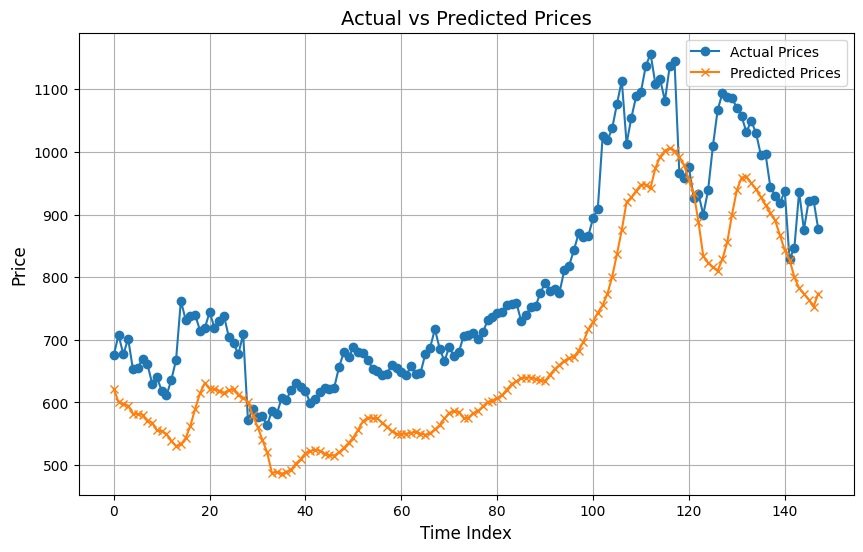

In [67]:
import matplotlib.pyplot as plt

# Step 1: Make Predictions
predicted_prices = model.predict(test_sequences)

# Step 2: Transform Predictions Back to Original Scale
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(test_labels.reshape(-1, 1))

# Step 3: Evaluate Performance
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = mean_squared_error(actual_prices, predicted_prices, squared=False)
mae = mean_absolute_error(actual_prices, predicted_prices)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Step 4: Visualize Predictions vs Actual Prices
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_prices)), actual_prices, label="Actual Prices", marker='o')
plt.plot(range(len(predicted_prices)), predicted_prices, label="Predicted Prices", marker='x')
plt.title('Actual vs Predicted Prices', fontsize=14)
plt.xlabel('Time Index', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid()
plt.show()
